In [1]:
import numpy as np
import sklearn
import os
import csv
import cv2
import math
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

correction = 0.2 #angle correction for left/right cameras
total_cameras = 3 #use right and left cameras too
batch_size = 128

# training dataset 
#user_path = '/Users/albertoescarlate/Dropbox/Udacity/_SDC_ND013/CARND-AllTerms-projects/CARND-Term1-projects'
user_path = ''
#base_path = user_path + '/data/data_small'
#base_path = user_path + '/data/data_xbox'
base_path = user_path + '/data/data_udacity'
#base_path = user_path + '/Users/albertoescarlate/Desktop'

# resizing values
new_w = 64
new_h = 64

# chosen model
CNN_model = "LeNet"
#CNN_model = "NVIDIA"
#CNN_model = "comma_ai"

epoch = 5

In [2]:
from random import random

# flip images horizontally
def flip_image(img, angle):
    img = cv2.flip(img, 1)
    angle = angle * -1.0
    return img, angle

def convert_color_image(img):
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return img

# crop bottom 25 pixels + crop 33.3% of image top (scenery above road) + resize it to 64 x 64
def crop_resize_image(img):
    shape = img.shape
    img = img[math.floor(shape[0]/3):shape[0]-25, 0:shape[1]]
    img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)    
    return img

# flip input image
def process_image(img, angle):
    if random() > 0.5:
        img, angle = flip_image(img, angle)
    img = convert_color_image(img)
    img = crop_resize_image(img)
    return img, angle

In [4]:
def load_data(sample):
    path = base_path + '/IMG/'

    name_center = path + sample[0].split('/')[-1]
    name_left = path + sample[1].split('/')[-1]
    name_right = path + sample[2].split('/')[-1]
    
    image_center = cv2.imread(name_center)
    image_left = cv2.imread(name_left)
    image_right = cv2.imread(name_right)

    angle_center = float(sample[3])
    angle_left = angle_center + correction
    angle_right = angle_center - correction

    return (image_center, image_left, image_right), (angle_center, angle_left, angle_right)
            
def generator(samples, batch_size, total_cameras=3):
    num_samples = len(samples)
    while 1: 
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                image, angle = load_data(batch_sample)
                for item in zip(image,angle): #iterate camera images and  steering angles
                    aug_image, aug_angle = process_image(item[0], item[1])
                    if abs(aug_angle) > 0.05:
                        images.append(aug_image)
                        angles.append(aug_angle)
                
            X_train = np.array(images)
            y_train = np.array(angles)
            yield X_train, y_train
            

In [5]:
def model_LeNet():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(64,64,3), output_shape=(64,64,3)))
    model.add(Convolution2D(6, 5, 5, border_mode="same", activation='elu', name='Conv1'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(6, 5, 5, border_mode="same", activation='elu', name='Conv2'))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dense(120, activation='elu', name='FC1'))
    model.add(Dense(84, activation='elu', name='FC2'))
    model.add(Dense(1, activation='elu', name='output'))
    
    return model

In [6]:
def model_comma_ai():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(64, 64, 3), output_shape=(64, 64, 3)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same", activation='elu', name='conv1'))
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='conv2'))
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same", activation='elu', name='conv3'))
    model.add(Flatten(name='flat'))
    model.add(Dropout(0.5, name='drop1'))
    model.add(ELU(name='elu1'))
    model.add(Dense(512, activation='elu', name='fully_connected1'))
    model.add(Dropout(0.5, name='drop2'))
    model.add(ELU(name='elu2'))
    model.add(Dense(1, name='output'))
    
    return model

In [7]:
def model_NVIDIA():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(64, 64, 3), output_shape=(64, 64, 3)))
    model.add(Convolution2D(24,5,5, border_mode="same", activation='elu', name='conv1'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(36,5,5, border_mode="same", activation='elu', name='conv2'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(48,5,5, border_mode="same", activation='elu', name='conv3'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(64,3,3, border_mode="same", activation='elu', name='conv4'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(64,3,3, border_mode="same", activation='elu', name='conv5'))
    model.add(Dropout(0.5))
    model.add(Flatten(name='flat'))
    model.add(Dense(100, activation='elu', name='fully_connected1'))
    model.add(Dense(50, activation='elu', name='fully_connected2'))
    model.add(Dense(10, activation='elu', name='fully_connected3'))
    model.add(Dense(1, activation='elu', name='output'))
    
    return model 

In [8]:
samples = []
path = base_path + '/driving_log.csv'
with open(path) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size)
validation_generator = generator(validation_samples, batch_size)


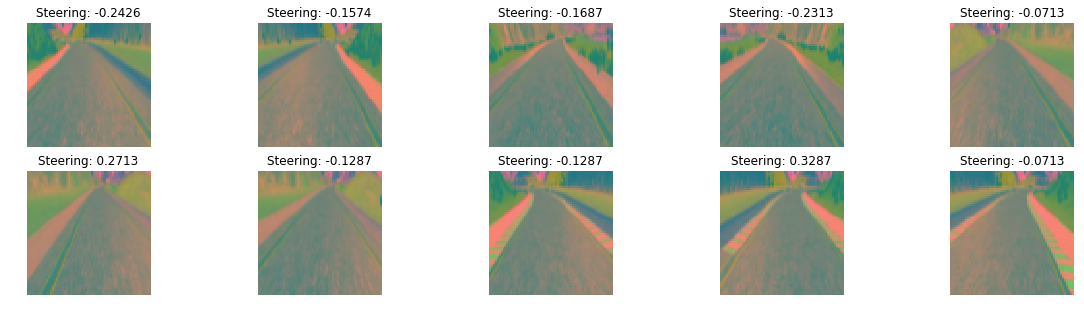

In [9]:
iterator = generator(train_samples, batch_size=10)
sample_images, sample_steerings = iterator.__next__()

plt.subplots(figsize=(20, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title("Steering: {:.4f}".format(sample_steerings[i]))
    plt.imshow(sample_images[i], cmap='Accent')
plt.show()

In [10]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.layers import Flatten, Lambda, ELU, Cropping2D, Input, MaxPooling2D
from keras.layers.convolutional import Convolution2D
from keras.regularizers import l2


if CNN_model == "comma_ai":
    model = model_comma_ai()
else:
    if CNN_model == "LeNet":
        model = model_LeNet() 
    else:
        if CNN_model == "NVIDIA":
            model = model_NVIDIA()
                       
print("Model =", CNN_model)
model.summary()
model.compile(loss='mse', optimizer='Adam')

history_object = model.fit_generator(train_generator, 
                                     samples_per_epoch=len(train_samples)*3/batch_size,
                                     validation_data=validation_generator,
                                     nb_val_samples=len(validation_samples),
                                     nb_epoch=5)

model.save('model.h5')
print("Model saved")

Using TensorFlow backend.


Model = LeNet
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
Conv1 (Convolution2D)            (None, 64, 64, 6)     456         lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 32, 6)     0           Conv1[0][0]                      
____________________________________________________________________________________________________
Conv2 (Convolution2D)            (None, 32, 32, 6)     906         maxpooling2d_1[0][0]             
_____________________________________________________________________________

/usr/local/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


297/150 [===========================================================] - 80s - loss: 0.0502 - val_loss: 0.1017
Epoch 2/5
285/150 [========================================================] - 63s - loss: 0.0974 - val_loss: 0.2633
Epoch 3/5
288/150 [=========================================================] - 65s - loss: 0.3202 - val_loss: 0.0380
Epoch 4/5
291/150 [=========================================================] - 62s - loss: 0.0563 - val_loss: 0.0900
Epoch 5/5
297/150 [===========================================================] - 67s - loss: 0.0971 - val_loss: 0.1070
Model saved


dict_keys(['val_loss', 'loss'])


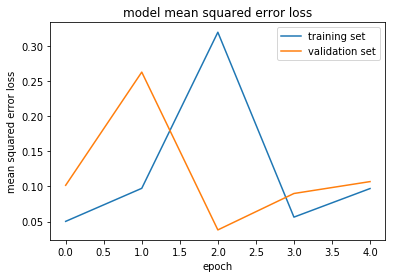

In [12]:
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()